In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

%matplotlib inline

In [100]:
data = pd.read_csv('../data/so.csv')

In [101]:
data = data[data.gender.isin(['Male', 'Female', 'Other'])]

In [102]:
data.gender.value_counts()

Male      51388
Female     3202
Other       274
Name: gender, dtype: int64

In [103]:
data.dogs_vs_cats.value_counts()

Dogs                      21852
Cats                      15508
Other (please specify)     7218
Name: dogs_vs_cats, dtype: int64

In [104]:
data.columns

Index(['Unnamed: 0', 'collector', 'country', 'un_subregion', 'so_region',
       'age_range', 'age_midpoint', 'gender', 'self_identification',
       'occupation', 'occupation_group', 'experience_range',
       'experience_midpoint', 'salary_range', 'salary_midpoint',
       'big_mac_index', 'tech_do', 'tech_want', 'aliens',
       'programming_ability', 'employment_status', 'industry',
       'company_size_range', 'team_size_range', 'women_on_team', 'remote',
       'job_satisfaction', 'job_discovery', 'dev_environment',
       'commit_frequency', 'hobby', 'dogs_vs_cats', 'desktop_os',
       'unit_testing', 'rep_range', 'visit_frequency', 'why_learn_new_tech',
       'education', 'open_to_new_job', 'new_job_value', 'job_search_annoyance',
       'interview_likelihood', 'how_to_improve_interview_process',
       'star_wars_vs_star_trek', 'agree_tech', 'agree_notice',
       'agree_problemsolving', 'agree_diversity', 'agree_adblocker',
       'agree_alcohol', 'agree_loveboss', 'agree_n

In [105]:
def df_to_cpd(df, target_var, parents=[],):
    variable_cardinality = df[target_var].nunique()
    if len(parents) == 0:
        values = [df[target_var].value_counts(normalize=True).values]
    else:
        df = df.dropna(subset=[target_var]+parents)
        evidence_card = [df[c].nunique() for c in parents]
        evidence = 1 #todo

In [106]:
model = BayesianModel([('gender', 'dogs_vs_cats'), ('age_midpoint', 'dogs_vs_cats')])
model.fit(data, estimator_type=MaximumLikelihoodEstimator, complete_samples_only=False)
infer = VariableElimination(model)
df = data

def ev(dictionary):
    return {k: list(df[k].unique()).index(v) for k,v in dictionary.items()}


In [107]:
print(infer.query(['dogs_vs_cats'], evidence=ev({'gender':'Male'}))['dogs_vs_cats'])

╒════════════════╤═════════════════════╕
│ dogs_vs_cats   │   phi(dogs_vs_cats) │
╞════════════════╪═════════════════════╡
│ dogs_vs_cats_0 │              0.3924 │
├────────────────┼─────────────────────┤
│ dogs_vs_cats_1 │              0.4143 │
├────────────────┼─────────────────────┤
│ dogs_vs_cats_2 │              0.1933 │
╘════════════════╧═════════════════════╛


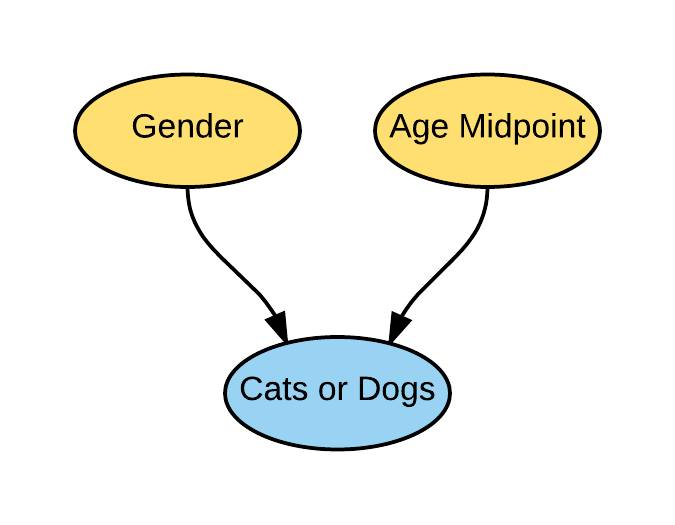

In [108]:
Image('../figures/catdog.png')

Picca voor *M. Bueno*

In [139]:
df_ = df.dropna(subset=['salary_range'])
df_ = df_[df_['salary_range'].str.contains('\$')]
df_['desktop_os'] = df_['desktop_os'].str.replace('Ubuntu|Debian|Fedora|Mint|Other Linux', 'Linux')
df_['desktop_os'] = df_['desktop_os'].str.replace('Windows.*', 'Windows')
df_['is_javascript'] = df_['tech_do'].str.contains('JavaScript')
df_['is_php'] = df_['tech_do'].str.contains('PHP')
df_['is_python'] = df_['tech_do'].str.contains('Python')
df_['salary_range'] = df_.salary_range.str.replace('\$[0-9]{3},000 - \$[0-9]{3},000', 'More than $100,000')
df_['salary_range'] = df_.salary_range.str.replace('More than \$200,000', 'More than $100,000')

In [140]:
model = BayesianModel([('age_range', 'star_wars_vs_star_trek'), 
                       ('age_range', 'experience_range'),
                       ('experience_range', 'salary_range'),
                       ('gender', 'salary_range'),
                       ('un_subregion', 'salary_range'),
                       ('gender', 'agree_diversity'),
                       ('agree_diversity', 'is_javascript'),
                       ('agree_diversity', 'is_php'),
                       ('agree_diversity', 'is_python'),
                       ('un_subregion', 'desktop_os'),
                       ('desktop_os', 'is_javascript'),
                       ('desktop_os', 'is_php'),
                       ('desktop_os', 'is_python'),
                       ('is_javascript', 'salary_range'),
                       ('is_php', 'salary_range'),
                       ('is_python', 'salary_range'),
                       ('age_range', 'desktop_os'),
                       ('un_subregion', 'agree_diversity'),])
model.fit(df_, estimator_type=MaximumLikelihoodEstimator, complete_samples_only=False)

In [141]:
out = open('cpds.txt', 'w', encoding='utf-8')
for cpd in model.get_cpds():
    out.write(str(cpd) + '\n')

In [130]:
df_['salary_range']

1         $40,000 - $50,000
3         Less than $10,000
6        More than $100,000
7         Less than $10,000
9         Less than $10,000
11        $10,000 - $20,000
12        Less than $10,000
13        Less than $10,000
14        $10,000 - $20,000
19        $10,000 - $20,000
20       $90,000 - $100,000
21        Less than $10,000
23        Less than $10,000
26        $40,000 - $50,000
28        $30,000 - $40,000
32        $10,000 - $20,000
33        $30,000 - $40,000
34        $10,000 - $20,000
35        Less than $10,000
36        $10,000 - $20,000
37        $20,000 - $30,000
38        $10,000 - $20,000
39        $10,000 - $20,000
40        $10,000 - $20,000
41        Less than $10,000
42        $70,000 - $80,000
45       $90,000 - $100,000
46        $20,000 - $30,000
47       More than $100,000
48        $30,000 - $40,000
                ...        
55987    More than $100,000
55988    More than $100,000
55989     $80,000 - $90,000
55990    More than $100,000
55991    More than $

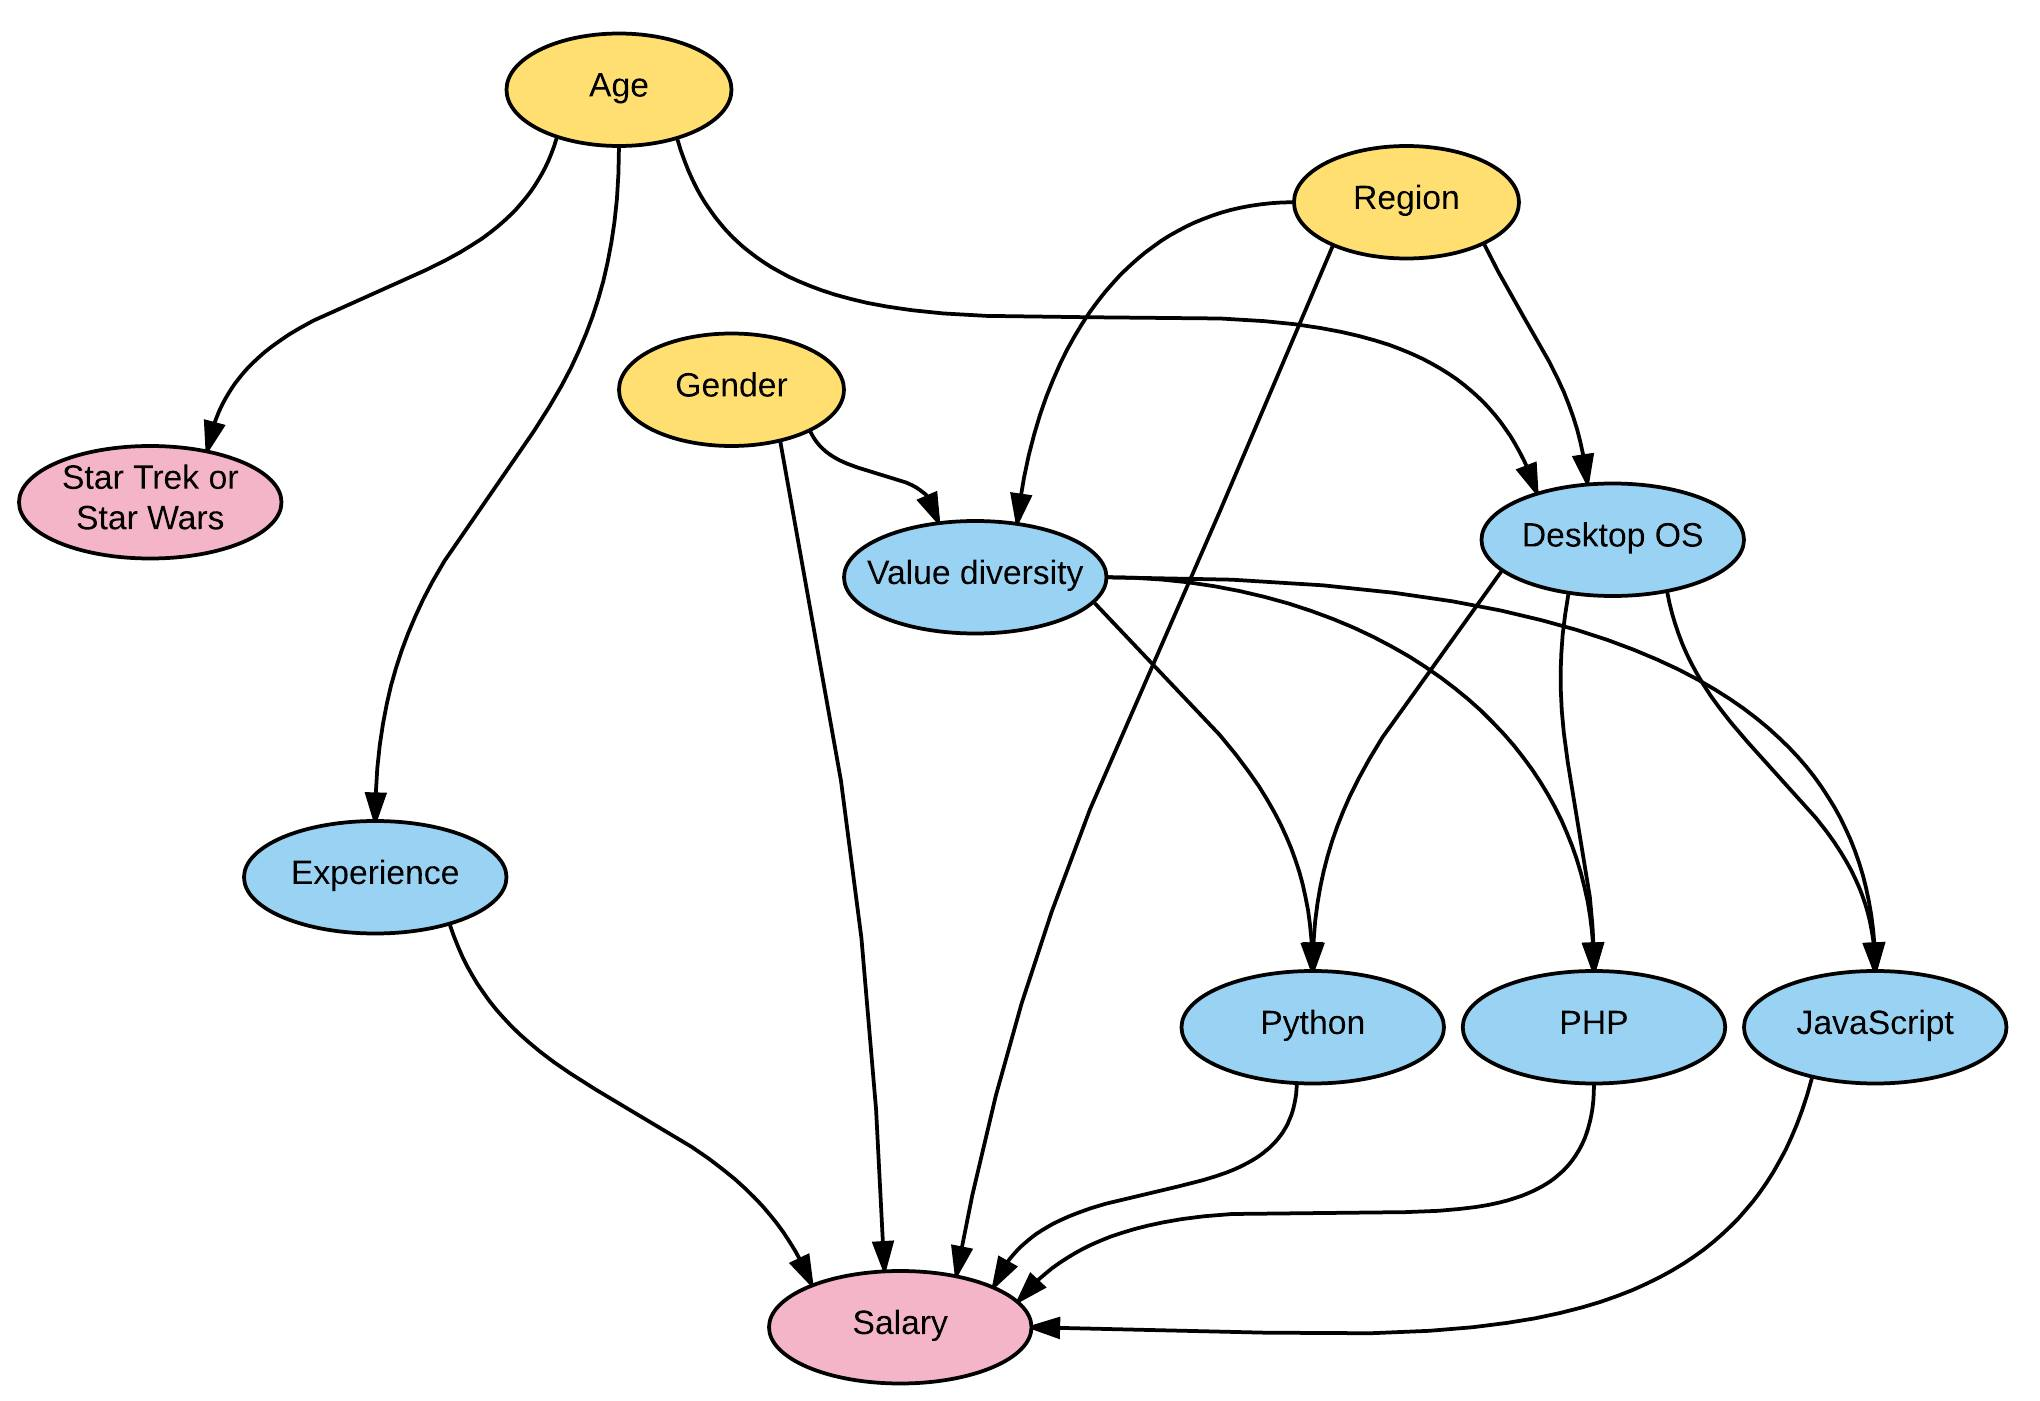

In [142]:
Image('../figures/network1.png')